In [1]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SciPy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import statistics as stats
from collections import defaultdict
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model                                                         

In [4]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()

In [5]:
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

y_train = tf.one_hot(y_train.astype(np.int32), depth=100)
y_test = tf.one_hot(y_test.astype(np.int32), depth=100)

inputs = tf.keras.layers.Input(shape=(32, 32, 3))

In [7]:
model_name = inception
input_t = (128,128,3)

model = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
#others for testing
model2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)


# get the layer index
def getLayerIndex(model_i, layer_name):
    for pos, layer_g in enumerate(model_i.layers):
        if layer_g.name == layer_name:
            return pos


# get the convolved layers into an array for looping
convolved_layers = []

for layer in model.layers:

    t = np.array(layer.get_weights()).ndim
    array = np.array(layer.get_weights())
    if (model_name != resnet50) or (model_name != vgg16):
        if (len(array) > 0) and (t > 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))
    if (model_name == resnet50) or (model_name == vgg16):
        if len(array) > 0 and (t != 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))

# get the total number of weights in the array
total_layer_weights = 0
sum_positives = 0
sum_negatives = 0

# create a dictionary with layer index and positive values identified
layer_positives_dict = defaultdict(list)

# create a dictionary for storing the layers and their +ve values probabilities
layer_probs_dict = defaultdict(list)

# list the convolved layers
for c_layer in range(len(convolved_layers)):
    # then print for each layer
    ####print("*******START LAYER: " + str(convolved_layers[c_layer]) + " **************** ")
    ### print("Batches:" + str(len(model.layers[convolved_layers[c_layer]].get_weights()[0])));
    ####print("Layer output size: " + str(model.layers[convolved_layers[c_layer]].get_weights()[0].shape))

    # create array for array matrices,feature values and convolved values for each layer
    layer_array_matrices = []
    layer_feature_sums = []
    layer_convolved_values_sum = []

    # get the arrays matrices(batches) pixel
    for i in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0])):
        # get the values for each feature
        ######print("channels(image):"+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])))
        for x in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])):
            ####print("Convolved image array :"+str(len(np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]))))

            # return all the values in the convolutional feature
            total_array = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x])
            # return all the negative values in the convolutional feature
            x2 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) < 0
            for c in range(len(x2)):
                ###print("all the trues in depth: " + str(c + 1) + " are for feature: " + str(x + 1))
                sum_negatives += sum(x2[c])
                # print(sum(x2[c]))
            # return all the values
            for y in range(len(total_array)):
                total_layer_weights += len(total_array[y])

            x1 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) > 0
            # get the values for each channel
            for a in range(len(x1)):
                # print("Pixel(matrix position): " + str(a + 1) + " Feature Map item: " + str(x + 1)+" Array: "+str(i+1)+" of "+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0])))
                # print("+ve image convolved values at position:" + str(a))
                # get the positive values ready to be passed through activation function for feature map
                value_pix = sum(x1[a])
                # get the positive values
                sum_positives += value_pix

                ######print(value_pix)
    list_sums = []
    list_sums.append((str(convolved_layers[c_layer]), sum_positives))
    layer_positives_dict.update(list_sums)

    # print the probabilities for each layer
    layer_pos_prob = sum_positives / total_layer_weights

    # create +ves values array
    positives_array = []
    for key, val in layer_positives_dict.items():
        # print(key, "corresponds to:",val," positive values")
        positives_array.append(val)
        ###used with softmax values
        # print(key, "corresponds to:", float(val))
        # positives_array.append(float(val))
        ###end of usage with softmax
        # create an array of positives and then use the softmax to get their distribution
        # probability

    # get the softmax values
    # p = tf.nn.softmax(positives_array)
    # print(p)
    list_layer_probs = []
    list_layer_probs.append((str(convolved_layers[c_layer]), layer_pos_prob))
    layer_probs_dict.update(list_layer_probs)

    # loop through the layer_probs_dictionary
    #for lyr, val in layer_probs_dict.items():
        #print(lyr, "Layer prob:", val)

# get the median number of layers to ensure the first layers deal with the feature extraction

median_layer = stats.median(convolved_layers)

# create dictionary for storing selected median layers
second_layer_probs_dict = defaultdict(list)
# store the new list of layers to be matched with the mean probability
second_half_layers = []

# store all probabilities for the selected upper half layers
second_half_probs = []
# loop through the layers and print those layers above the median
for lyr, val in layer_probs_dict.items():
    # print(lyr, "Layer prob:", val)
    if int(lyr) > median_layer:
        # store the probabilities of the upper half selected convolved layers
        print(lyr, "Layer prob:", val)
        # update the sum of selected layers probabilities
        second_half_probs.append(val)
        second_half_layers.append((lyr, val))
        second_layer_probs_dict.update(second_half_layers)

# get the mean of the layers
selected_layers_mean = stats.mean(second_half_probs)
final_selected_layers = []
# now get the final layers list whose value exceed the mean
for s_lyr, v in second_layer_probs_dict.items():
    # get the probabilities that are lower than the mean probability
    if v < selected_layers_mean:
        # store the probabilities of the upper half selected convolved layers
        final_selected_layers.append(s_lyr)

# print(second_half_layers)
# print(str(convolved_layers[c_layer]) + " probability: " + str(layer_pos_prob))
# print("*******END LAYER: " + str(convolved_layers[c_layer]) + " **************** ")
#model.trainable=False
# use the selected layers
# use the selected layers
s_h_layers =[1,54,41,31,21] #higher kullback
s_l_layers =[108,154,241,121] #lower kullback
for sb_layer in model.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model, sb_layer.name)
    #for b in final_selected_layers:
    for b in s_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)
            
# for model 2
for sbs_layer in model2.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model2, sbs_layer.name)
    #for b in final_selected_layers:
    for b in s_l_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

153 Layer prob: 0.47680588709948557
154 Layer prob: 0.4755090552320906
155 Layer prob: 0.4753669716888586
165 Layer prob: 0.47511162689235614
168 Layer prob: 0.4744336452623567
171 Layer prob: 0.47444871713506
172 Layer prob: 0.47388908217501385
177 Layer prob: 0.4735913680137435
178 Layer prob: 0.4727567811364222
184 Layer prob: 0.47304791609964514
185 Layer prob: 0.472851803912614
186 Layer prob: 0.4719519949944997
187 Layer prob: 0.47187031497469206
197 Layer prob: 0.4718245858768004
200 Layer prob: 0.4714651132618618
203 Layer prob: 0.47135721162832145
204 Layer prob: 0.4705969971401335
209 Layer prob: 0.47024238688476644
210 Layer prob: 0.469800143362268
216 Layer prob: 0.4697017729729312
217 Layer prob: 0.46864275933508914
218 Layer prob: 0.4671214002843771
219 Layer prob: 0.46694459843702496
229 Layer prob: 0.46641793014148336
232 Layer prob: 0.46591301789117484
235 Layer prob: 0.46517157894736844
236 Layer prob: 0.4649891043782527
241 Layer prob: 0.46215258488791783
242 Layer p

In [8]:
upsamp1 = tf.keras.layers.UpSampling2D((2,2))(inputs)
upsamp2 = tf.keras.layers.UpSampling2D((2,2))(upsamp1)

pre_trained_model = model(upsamp2)
dense41 = tf.keras.layers.Dense(128, activation='relu')(pre_trained_model)
x1 = Flatten()(dense41)
predictions = tf.keras.layers.Dense(100, activation='softmax')(x1)


t_model = Model(inputs = inputs, outputs = predictions)
t_model.summary()

pre_trained_model2 = model2(upsamp2)
dense42 = tf.keras.layers.Dense(128, activation='relu')(pre_trained_model2)
x2 = Flatten()(dense42)
predictions2 = tf.keras.layers.Dense(100, activation='softmax')(x2)

t_model2 = Model(inputs = inputs, outputs = predictions2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
dense (Dense)                (None, 2, 2, 128)         262272    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300 

In [9]:
t_model.compile(optimizer=optimizers.SGD(lr=1e-5,momentum=0.9), loss=losses.categorical_crossentropy, metrics=['accuracy'])
history = t_model.fit(x_train, y_train, batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=50, verbose=1)

#for model2
###t_model2.compile(optimizer=optimizers.SGD(lr=1e-5,momentum=0.9), loss=losses.categorical_crossentropy, metrics=['accuracy'])
##history2 = t_model2.fit(x_train, y_train, batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=50, verbose=1)


Epoch 1/50
907/907 [==============================] - 112s 105ms/step - loss: 4.1172 - accuracy: 0.1164 - val_loss: 2.2280 - val_accuracy: 0.4357
Epoch 2/50
907/907 [==============================] - 94s 103ms/step - loss: 1.9399 - accuracy: 0.5313 - val_loss: 1.0346 - val_accuracy: 0.7670
Epoch 3/50
907/907 [==============================] - 94s 103ms/step - loss: 0.9493 - accuracy: 0.7839 - val_loss: 0.5481 - val_accuracy: 0.8852
Epoch 4/50
907/907 [==============================] - 94s 103ms/step - loss: 0.5472 - accuracy: 0.8759 - val_loss: 0.3470 - val_accuracy: 0.9228
Epoch 5/50
907/907 [==============================] - 93s 103ms/step - loss: 0.3682 - accuracy: 0.9162 - val_loss: 0.2491 - val_accuracy: 0.9441
Epoch 6/50
907/907 [==============================] - 93s 103ms/step - loss: 0.2695 - accuracy: 0.9371 - val_loss: 0.1947 - val_accuracy: 0.9543
Epoch 7/50
907/907 [==============================] - 93s 103ms/step - loss: 0.2189 - accuracy: 0.9476 - val_loss: 0.1618 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



907/907 [==============================] - 94s 103ms/step - loss: 0.0643 - accuracy: 0.9825 - val_loss: 0.0702 - val_accuracy: 0.9804
Epoch 20/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0621 - accuracy: 0.9836 - val_loss: 0.0688 - val_accuracy: 0.9807
Epoch 21/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0596 - accuracy: 0.9842 - val_loss: 0.0667 - val_accuracy: 0.9815
Epoch 22/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0510 - accuracy: 0.9862 - val_loss: 0.0632 - val_accuracy: 0.9814
Epoch 24/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0508 - accuracy: 0.9870 - val_loss: 0.0621 - val_accuracy: 0.9819
Epoch 25/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0389 - accuracy: 0.9892 - val_loss: 0.0535 - val_accuracy: 0.9845
Epoch 32/50
907/907 [==============================] - 94s 103ms/step - loss: 0.0372 - accuracy: 0.9901 - val_loss: 0.0536 - val_accurac

In [10]:
t_model2.compile(optimizer=optimizers.SGD(lr=1e-5,momentum=0.9), loss=losses.categorical_crossentropy, metrics=['accuracy'])
history2 = t_model2.fit(x_train, y_train, batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=50, verbose=1)


Epoch 1/50
907/907 [==============================] - 101s 105ms/step - loss: 4.2004 - accuracy: 0.0948 - val_loss: 2.4361 - val_accuracy: 0.4147
Epoch 2/50
907/907 [==============================] - 94s 104ms/step - loss: 2.0058 - accuracy: 0.5126 - val_loss: 1.0676 - val_accuracy: 0.7576
Epoch 3/50
907/907 [==============================] - 94s 104ms/step - loss: 0.9507 - accuracy: 0.7825 - val_loss: 0.5677 - val_accuracy: 0.8755
Epoch 4/50
907/907 [==============================] - 94s 104ms/step - loss: 0.5521 - accuracy: 0.8739 - val_loss: 0.3529 - val_accuracy: 0.9210
Epoch 5/50
907/907 [==============================] - 94s 104ms/step - loss: 0.3763 - accuracy: 0.9110 - val_loss: 0.2533 - val_accuracy: 0.9399
Epoch 6/50
907/907 [==============================] - 94s 104ms/step - loss: 0.2842 - accuracy: 0.9323 - val_loss: 0.2003 - val_accuracy: 0.9494
Epoch 7/50
907/907 [==============================] - 94s 104ms/step - loss: 0.2287 - accuracy: 0.9434 - val_loss: 0.1628 - val_a

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


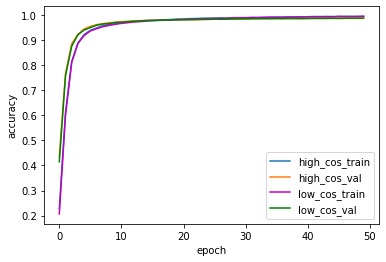

In [17]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['accuracy'], color='m')
plt.plot(history2.history['val_accuracy'], color='g')
#plt.title('Positive Cosine Similarity Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['high_cos_train', 'high_cos_val','low_cos_train','low_cos_val'], loc='lower right')
#plt.savefig('cosine_sim.svg', format='svg', dpi=600) 
#plt.savefig('cosine_sim.eps', format='eps', dpi=600) 
#plt.legend(['high_cos_train', 'high_cos_val','low_cos_train','low_cos_val'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('positive_cosine_similarity_mnist_inception.eps', dpi=1000, format="eps", bbox_inches="tight")
plt.show()

#fig2 = plt.figure()
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.plot(history2.history['loss'])
#plt.plot(history2.history['val_loss'])
#plt.title('Positive Negative Cosine Similarity Model Loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['high_cos_train', 'high_cos_val','low_cos_train','low_cos_val'], loc='upper right')
#fig2.savefig('cosine_Loss.png', format='png', dpi=600)
#plt.show()